# __Prueba técnica - Skandia__
Juan Sebastian Moncada Aguilar

### 1. Generar una conexión a la base de datos en python usando las librerías necesarias para la conexión (Los accesos y URL son enviados en el correo de citación).

In [263]:
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'ODBC Driver 18 for SQL Server']


In [264]:
import matplotlib.pyplot as plt
import os
import plotly.express as px
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

"""
La conexión a la base de datos es realizada a través de un archivo .env, el cual es un archivo de texto que contiene las credenciales
proporcionadas por Skandia para conectarse a la base de datos. Esto se hace como buena practica, con el fin de no dejar
expuestos en el notebook usuarios y contraseñas.
"""

load_dotenv()

server = os.getenv('SERVER')
database = os.getenv('DATABASE')
username = os.getenv('USERNAME')
password = os.getenv('PASS')

# Establecer conexión
conn = pyodbc.connect(
    f'DRIVER={{ODBC Driver 18 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server')

### 2. Por cada tabla de la base de datos genere el dataframe de pandas, guarde la tabla en formato parquet y realice un análisis descriptivo de las tablas que considere más relevantes.

In [265]:
table_dict = {}

tables = pd.read_sql("SELECT table_name FROM information_schema.tables WHERE table_type='BASE TABLE'", conn)

for table in tables['table_name']:
    df = pd.read_sql(f'SELECT * FROM {table}', conn)
    table_dict[table] = df
    df.to_parquet(f'files/database_files/{table}.parquet')

C:\Users\JUANC\AppData\Local\Temp\ipykernel_10568\608780005.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JUANC\AppData\Local\Temp\ipykernel_10568\608780005.py:6: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [266]:
table_dict.keys()

dict_keys(['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track'])

In [267]:
album_df = table_dict['Album'] # Cuantos albumes, artistas + comunes
artist_df = table_dict['Artist']
customer_df = table_dict['Customer'] # Cuantos clientes hay, quienes son los + frecuentes.
employee_df = table_dict['Employee']
genre_df = table_dict['Genre']
invoice_df = table_dict['Invoice'] # Total vendido, paises con + ventas
invoiceline_df = table_dict['InvoiceLine']
mediatype_df = table_dict['MediaType']
playlist_df = table_dict['Playlist']
pltrack_df = table_dict['PlaylistTrack']
track_df = table_dict['Track']

In [268]:
inventory_df = track_df.merge(album_df, how='left', on='AlbumId') \
                       .merge(artist_df, how='left', on='ArtistId') \
                       .merge(genre_df, how='left', on='GenreId')

inventory_df = inventory_df.rename(columns={
                                     'Name_x': 'Track',
                                     'Name_y': 'Artist',
                                     'Name': 'Genre'  
                                   })

inventory_df.set_index('TrackId', inplace=True)

In [269]:
inventory_df.head()

,Track,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,Title,ArtistId,Artist,Genre
TrackId,,,,,,,,,,,,
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99,For Those About To Rock We Salute You,1,AC/DC,Rock
2,Balls to the Wall,2,2,1,"U. Dirkschneider, W. Hoffmann, H. Frank, P. Ba...",342562,5510424,0.99,Balls to the Wall,2,Accept,Rock
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99,Restless and Wild,2,Accept,Rock
4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99,Restless and Wild,2,Accept,Rock
5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99,Restless and Wild,2,Accept,Rock


In [270]:
inventory_df['Minutes'] = inventory_df['Milliseconds']/(60*1000)

In [271]:
inventory_df['UnitPrice'].describe()

count    3503.000000
mean        1.050805
std         0.239006
min         0.990000
25%         0.990000
50%         0.990000
75%         0.990000
max         1.990000
Name: UnitPrice, dtype: float64

- Se observa que hay un total de 3503 canciones disponibles en el inventario. 
- El precio promedio de cada canción es de $1.05
- El precio más bajo por canción es de $0.99
- El precio más alto por canción es de $1.99
- El 75% de las canciones en inventario tienen un precio de $0.99

In [272]:
inventory_df['Minutes'].describe()

count    3503.000000
mean        6.559987
std         8.916757
min         0.017850
25%         3.454683
50%         4.260567
75%         5.360750
max        88.115883
Name: Minutes, dtype: float64

- La duración promedio de cada canción es de 6.55 minutos.
- La canción más corta es de tan solo 0.01 minutos.
- La canción más extensa es de 88.11 minutos.
- El 25% de las canciones en inventario tienen una duración inferior o igual a 3.45 minutos.
- El 50% de las canciones en inventario tienen una duración inferior o igual a 4.26 minutos.
- El 75% de las canciones en inventario tienen una duración inferior o igual a 5.36 minutos.

In [273]:
print(inventory_df['Artist'].nunique())
print(inventory_df['Genre'].nunique())
print(inventory_df['AlbumId'].nunique())

204
25
347


En la tienda:
- Hay canciones de 204 artistas diferentes.
- Hay canciones de 25 géneros diferentes.
- Hay 347 albumes diferentes.

### Canciones en inventario por artista

In [274]:
top_5_pivot_table = (inventory_df['Artist'].value_counts()
                     .reset_index(name='Song Count')
                     .assign(Percentage=lambda x: (x['Song Count'] / x['Song Count'].sum()) * 100)
                     .nlargest(5, 'Song Count'))

top_5_pivot_table.rename(columns={'index': 'Artist'}, inplace=True)
top_5_pivot_table

,Artist,Song Count,Percentage
0,Iron Maiden,213,6.080502
1,U2,135,3.853840
2,Led Zeppelin,114,3.254353
3,Metallica,112,3.197259
4,Lost,92,2.626320


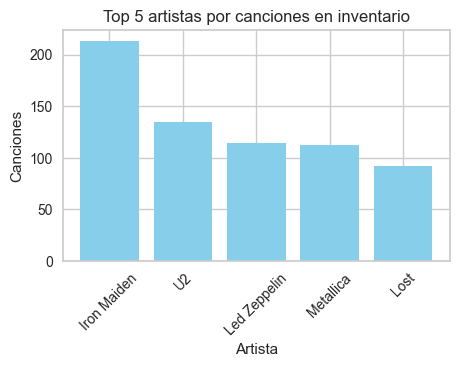

In [275]:
plt.figure(figsize=(5, 3))
plt.bar(top_5_pivot_table['Artist'], top_5_pivot_table['Song Count'], color='skyblue')
plt.xlabel('Artista')
plt.ylabel('Canciones')
plt.title('Top 5 artistas por canciones en inventario')
plt.xticks(rotation=45)
plt.show()

- Se observa que los artistas con más canciones en el inventario son Iron Maiden con 213 (6.08%); U2 con 135 (3.85%) y Led Zeppelin con 114 (3.25%). De hecho, estas 3 bandas representan cerca del 13% del inventario total. En el top 5 se observa otras bandas como Metallica y Lost.
Con esta información se puede iniciar a plantear hipotesis como:
    - ¿La empresa está enfocada en la venta de canciones de Rock?
    - ¿La demanda de canciones está concentrada en el género Rock?

### Canciones en inventario por género

Top 5

In [276]:
top_5_pivot_table = (inventory_df['Genre'].value_counts()
                     .reset_index(name='Song Count')
                     .assign(Percentage=lambda x: (x['Song Count'] / x['Song Count'].sum()) * 100)
                     .nlargest(5, 'Song Count'))

top_5_pivot_table.rename(columns={'index': 'Genre'}, inplace=True)
top_5_pivot_table

,Genre,Song Count,Percentage
0,Rock,1297,37.025407
1,Latin,579,16.528690
2,Metal,374,10.676563
3,Alternative & Punk,332,9.477591
4,Jazz,130,3.711105


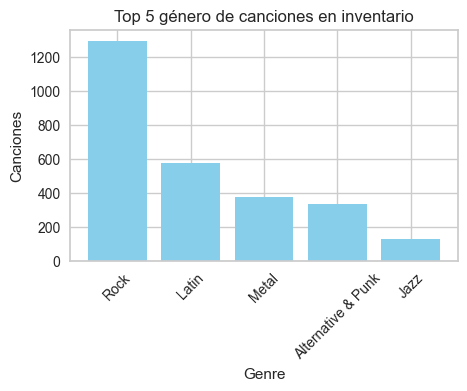

In [277]:
plt.figure(figsize=(5, 3))
plt.bar(top_5_pivot_table['Genre'], top_5_pivot_table['Song Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Canciones')
plt.title('Top 5 género de canciones en inventario')
plt.xticks(rotation=45)
plt.show()

- Se observa que el género con mayor participación en el inventario es el Rock, con un total 1297 canciones que corresponden al 37.02% del total. Esto evidencia que efectivamente la tienda tiene un fuerte enfoque en canciones de este género.

- Cabe destacar que el género Latin (latino) tiene una participación importante en el inventario con 579 canciones (16.52%).

Bottom 5

In [278]:
bottom_5_pivot_table = (inventory_df['Genre'].value_counts()
                     .reset_index(name='Song Count')
                     .assign(Percentage=lambda x: (x['Song Count'] / x['Song Count'].sum()) * 100)
                     .nsmallest(5, 'Song Count'))

bottom_5_pivot_table.rename(columns={'index': 'Genre'}, inplace=True)
bottom_5_pivot_table

,Genre,Song Count,Percentage
24,Opera,1,0.028547
23,Rock And Roll,12,0.342564
22,Science Fiction,13,0.371110
21,Bossa Nova,15,0.428204
20,Comedy,17,0.485298


- Se observa que el género con menor participación en el inventario es Opera con solo 1 canción (0.02%).
- El género Rock And Roll es el segundo con menos canciones, con un total de 12 (0.34%)
- El tercer género con menos canciones es Science Fiction con 13 (0.37%)

In [279]:
invoiceline_df

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1
...,...,...,...,...,...
2235,2236,411,3136,0.99,1
2236,2237,411,3145,0.99,1
2237,2238,411,3154,0.99,1
2238,2239,411,3163,0.99,1


In [280]:
invoice_df

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2021-01-01,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2021-01-02,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2021-01-03,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2021-01-06,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2021-01-11,69 Salem Street,Boston,MA,USA,2113,13.86
...,...,...,...,...,...,...,...,...,...
407,408,25,2025-12-05,319 N. Frances Street,Madison,WI,USA,53703,3.96
408,409,29,2025-12-06,796 Dundas Street West,Toronto,ON,Canada,M6J 1V1,5.94
409,410,35,2025-12-09,"Rua dos Campeões Europeus de Viena, 4350",Porto,None,Portugal,None,8.91
410,411,44,2025-12-14,Porthaninkatu 9,Helsinki,None,Finland,00530,13.86


- Se observa que la tienda ha realizado 412 transacciones de ventas. -->

#### Analisis Tabla Ventas

In [281]:
sales_df = invoice_df.merge(invoiceline_df, how='left', on = 'InvoiceId')\
                    .merge(inventory_df, how='left', on='TrackId')
sales_df['Total'] = sales_df['UnitPrice_y']

In [282]:
print(sales_df['Total'].sum())
print(sales_df['Total'].mean())

2328.6000000000004
1.0395535714285715


- En total, la tienda ha vendido $2328.
- El ticket promedio de compra es de $1.039.

In [283]:
sales_df['InvoiceDate'] = pd.to_datetime(sales_df['InvoiceDate'])
ventas = sales_df.groupby(sales_df['InvoiceDate'].dt.to_period('M'))['Total'].sum().reset_index()
ventas.columns = ['Mes', 'Ventas Totales']
ventas['Mes'] = ventas['Mes'].dt.to_timestamp()

fig = px.line(ventas, x='Mes', y='Ventas Totales', title='Ventas por mes USD',
              labels={'Mes': 'Mes', 'Ventas Totales': 'Ventas Totales'}, width=1200, height=500)
fig.show()

- De acuerdo con el comportamiento mensual de ventas, se observan diversos meses con niveles de compra constantes, rondando los $37. Sin embargo, se destacan algunos picos los cuales podrian estar asociados a lanzamientos de albumes y canciones de bandas que hacen parte del género core de la tienda: el rock. Por otro lado, se resalta una caida pronunciada en el volumen de ventas en noviembre de 2023, y otra caida leve en febrero de 2025.

In [284]:
ventas = sales_df.groupby('BillingCity')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(10)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Ciudades con más ventas USD',
             labels={'Ciudad': 'Ciudad', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales', width=600, height=500)
fig.show()

- La ciudad con más ventas es Praga, en Republica Checha, con $90.24.
- Ciudades como Mountain View, Paris, Londres, Sao Paulo y Berlin presentan ventas cercanas a los $75.
- Es de resaltar que en el top 10 de ciudades con más ventas, 6 de ellas son europeas, 2 norteamericanas y 2 suramericanas.

In [285]:
ventas = sales_df.groupby('BillingCountry')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(10)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Países con más ventas USD',
             labels={'Ciudad': 'País', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)
fig.show()

- USA es el país con más ventas, con $523, seguido con Canadá con $303. Con esto se muestra lo importante que es el mercado norteamericano para la tienda en terminos de ingresos.

In [286]:
ventas = sales_df.groupby('Genre')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(10)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Géneros con más ventas USD',
             labels={'Ciudad': 'Género', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)
fig.show()

- Tal y como lo apuntaban las hipotesis presentadas anteriormente, el Rock es el género con mayo volumen de ventas con $826. Con un poco menos del 50% de las ventas de Rock, el género Latin tiene ventas por $382 y Metal por $261. Aquí se muestra como la estrategia de inventarios de la tienda es acorde a su volumen de ventas.

In [287]:
ventas = sales_df.groupby('Track')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(10)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Canciones con más ventas USD',
             labels={'Ciudad': 'Canción', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)

fig.show()

- La canción con más ventas es The Trooper de Iron Maiden con $4.95, seguida de Pilot con ventas iguales a $3.98.

In [288]:
ventas = sales_df.groupby('Artist')['Total'].sum().reset_index()
ventas.columns = ['Artista', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(10)

fig = px.treemap(ventas, path=['Artista'], values='Ventas Totales',
                 title='Top 10 artistas con más ventas',
                 labels={'Artista': 'Artista'},
                 hover_data={'Ventas Totales': True},
                 width=600,
                 height=500,)

fig.update_traces(textinfo='label+value', textfont=dict(size=15))
fig.show()

- Los artistas con mayor volumen de ventas son:
    - Iron Maiden
    - U2
    - Lost
    - Metallica
    - Deep Purple

En este punto se destaca como  en el top 5 de artistas, hay 3 bandas britanicas: Iron Maiden, U2 y Deep Purple.

### 3. De la tabla Customer realice un conteo y agrupe por estado y ciudad, y grafico con el top 5 de los países con mayor cantidad de clientes.

In [289]:
customer_group = customer_df.groupby(['State', 'City']).size().reset_index(name='Count')

fig = px.treemap(customer_group, 
                 path=['State', 'City'],
                 values='Count',
                 title='Clientes por Estado y Ciudad',
                 labels={'City': 'Ciudad', 'Count': 'Cantidad de Clientes'})
fig.update_traces(textinfo='label+value', textfont=dict(size=15))
fig.show()

- Se destaca que los estados con mayor cantidad de clientes son California (USA) y Sao Paulo (Brasil) con 3 clientes cada uno. Los cuales se distribuyen en las ciudad de Mountain View y Cupertino, y Sao Paulo y San Jose dos Campos, respectivamente.

In [290]:
top_countries = customer_df['Country'].value_counts().head(5).reset_index()
top_countries.columns = ['Country', 'Number of Customers']

fig = px.bar(top_countries, 
             x='Country', 
             y='Number of Customers',
             title='Top 5 países con mayor cantidad de clientes',
             labels={'Country': 'País', 'Number of Customers': 'Número de clientes'},
             text='Number of Customers', width=700, height=500)
fig.update_traces(texttemplate='%{text}', textposition='auto')
fig.update_layout(xaxis_title='País', yaxis_title='Número de Clientes')
fig.show()

- USA encabeza la lista de los paises con más clientes, con un total de 13. Posteriormente se encuentra Canadá, con 8 clientes. Aquí se demuestra lo importante que es el mercado norteamericano para la tienda.

### 4. De las tablas Invoice y InvoiceLine realice un análisis donde indique cuales son los 5 tracks más vendidos, los 5 artistas que más venden, el mes donde más ventas se tienen y realice una gráfica con los 5 géneros más vendidos.

In [291]:
ventas = sales_df.groupby('Track')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(5)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Canciones con más ventas USD',
             labels={'Ciudad': 'Canción', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)

fig.show()

- La canción con más ventas es The Trooper de Iron Maiden con $4.95, seguida de Pilot con ventas iguales a $3.98

In [293]:
ventas = sales_df.groupby('Artist')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(5)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Artistas con más ventas USD',
             labels={'Ciudad': 'Canción', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)

fig.show()

- Los artistas con mayor volumen de ventas son:
    - Iron Maiden
    - U2
    - Lost
    - Metallica
    - Deep Purple

En este punto se destaca como  en el top 5 de artistas, hay 3 bandas britanicas: Iron Maiden, U2 y Deep Purple.

In [294]:
sales_df['Mes'] = sales_df['InvoiceDate'].dt.month 
ventas_por_mes = sales_df.groupby('Mes')['Total'].sum().reset_index()
ventas_por_mes.columns = ['Mes', 'Ventas Totales']
ventas_por_mes['Mes'] = ventas_por_mes['Mes'].map({1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
                                                      5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
                                                      9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'})

fig = px.bar(ventas_por_mes, 
             x='Mes', 
             y='Ventas Totales', 
             title='Ventas por mes',
             labels={'Mes': 'Mes', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)
fig.update_traces(texttemplate='%{text}', textposition='auto', textangle = -90)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

- Se observa que los meses con mayor volumen de ventas son Enero y Junio, respectivamente. Llama la atención que estos meses sean los de mayor volumen, mostrando una posible estacionalidad que se presenta aproximadamente cada 6 meses. Por otro lado, el mes con menos ventas es noviembre.

In [296]:
ventas = sales_df.groupby('Genre')['Total'].sum().reset_index()
ventas.columns = ['Ciudad', 'Ventas Totales']
ventas = ventas.sort_values(by='Ventas Totales', ascending=True).tail(5)

fig = px.bar(ventas, y='Ciudad', x='Ventas Totales', 
             title='Género con más ventas USD',
             labels={'Ciudad': 'Canción', 'Ventas Totales': 'Ventas Totales'},
             text='Ventas Totales',
             width=600,
             height=500)

fig.show()

- Tal y como lo apuntaban las hipotesis presentadas anteriormente, el Rock es el género con mayo volumen de ventas con $7720. Con un poco menos del 50% de las ventas de Rock, el género Latin tiene ventas por $3472 y Metal por 2093. Aquí se muestra como la estrategia de inventarios de la tienda es acorde a su volumen de ventas.